# Melanoma Detection 

### AIM - Multiclass Classification model using a custom convolutional neural network in TensorFlow
-----------------------------------------------------------------------------------------------------------------

### Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dropout,Dense,MaxPooling2D,BatchNormalization
import keras_cv
from glob import glob

import warnings
warnings.filterwarnings("ignore")

C:\Users\sheik\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Using TensorFlow backend


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('./Train')
data_dir_test = pathlib.Path('./Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
# Note keras.preprocessing was deprecated in v2.9.1, utils should be used instead.

from tensorflow.keras.utils import load_img

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

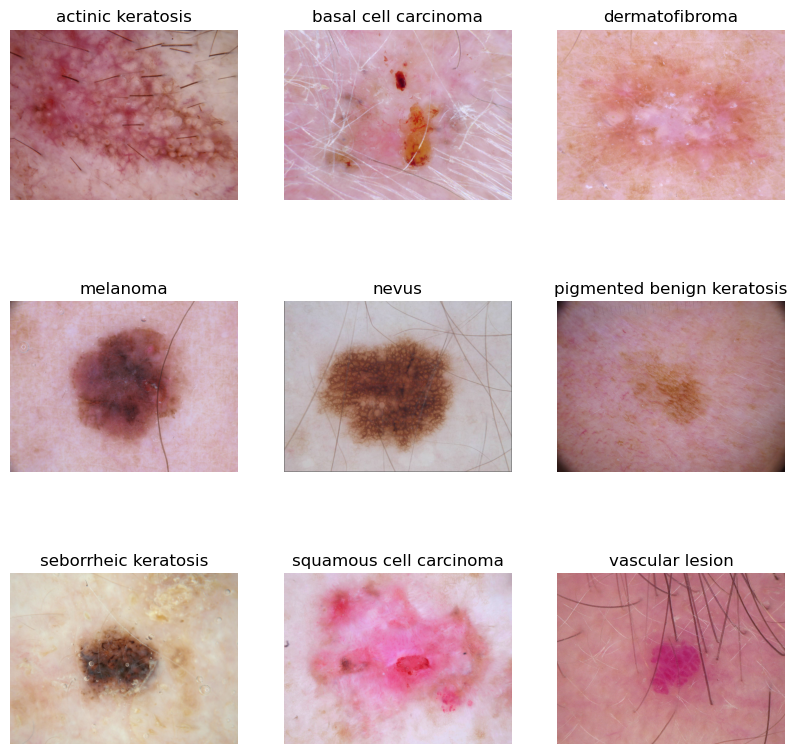

In [10]:
plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

As per Evaluation Rubrics, creating 1 st model of CNN with only optmiser and Loss function with 20 epoch

### Model Creation [ Scenario 1 - CNN Model with Optmiser & Loss Function]

In [12]:
# Note the first layer (Rescaling(1./255) rescales the RGB channel values.

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

### Model Compilation

#### Justification for optimizer choice.
While stochastic gradient descent ('sgd') is known to generalise better than adaptive moment estimation ('adam'), we have opted to use adam due to time constraints as it has a tendency to converge faster. The project pipeline states that the number of epochs to use be 20, so this makes sense considering the specific circumstances of this project. Ideally, the use of an ensemble approach applying both optimizers may be a better choice, but is outside the constraints of this project.

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Model Training

In [15]:
epochs = 20
history = model.fit(
  cached_train_ds,
  validation_data=cached_val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 11s 145ms/step - loss: 2.0254 - accuracy: 0.2210 - val_loss: 2.2900 - val_accuracy: 0.2174
Epoch 2/20
56/56 [==============================] - 8s 135ms/step - loss: 1.8096 - accuracy: 0.3326 - val_loss: 2.6151 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 8s 137ms/step - loss: 1.7784 - accuracy: 0.3493 - val_loss: 3.0012 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 8s 135ms/step - loss: 1.6084 - accuracy: 0.4208 - val_loss: 2.3410 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 8s 136ms/step - loss: 1.5686 - accuracy: 0.4481 - val_loss: 2.3273 - val_accuracy: 0.2174
Epoch 6/20
56/56 [==============================] - 8s 136ms/step - loss: 1.5087 - accuracy: 0.4771 - val_loss: 2.8671 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 8s 137ms/step - loss: 1.4044 - accuracy: 0.5123 - val_loss: 2.8028 - val_accuracy: 0.3043
Epo

### Visualization of training results

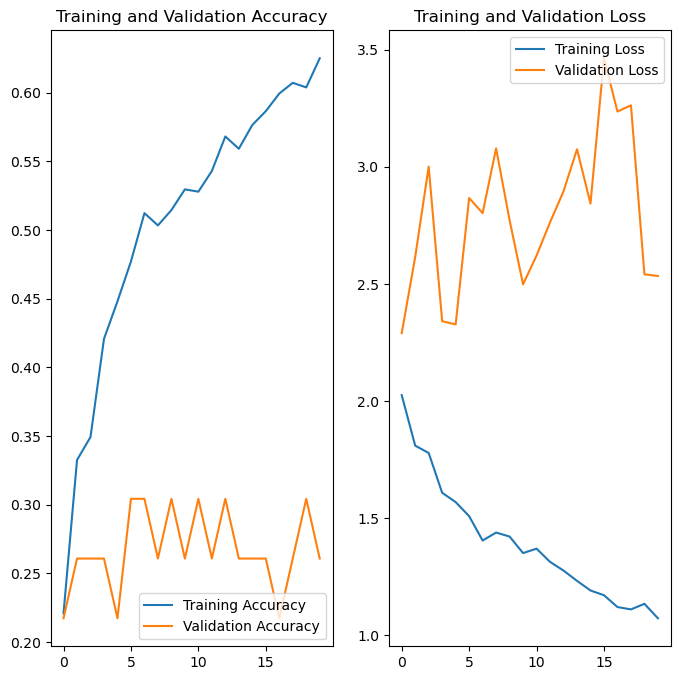

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations

There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

## Data Augmentation

Data augmentation 
The data augmentation performed will follow the recommendations found in the research paper Data Augmentation for Skin Lesion Analysis, Perez et al. 2018
https://arxiv.org/abs/1809.01442
The research paper investigated the impact of 13 data augmentation approaches on the performance of three CNNS (Inception-v4, ResNet, and DenseNet). The best augmentation scenario in Perez et al.'s paper was a a combination of geometric and colour transformations. To approximate this with the available keras layer types, we have opted for a mixture of RandomFlip, RandomRotation and RandomContrast and RandomBrightness, and the keras_cv augmentation layer of RandomColorDegeneration. We acknowledge the limitations of this approach, as our CNN does not have identical structure to the CNNs investigated in the paper, even though the application was melanoma classification.

### Creation of data augmentation layer architecture for reuse

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3),
    keras_cv.layers.RandomColorDegeneration(0.5)
])

### Illustration of data augmentation showing 9 exemplars for a single image

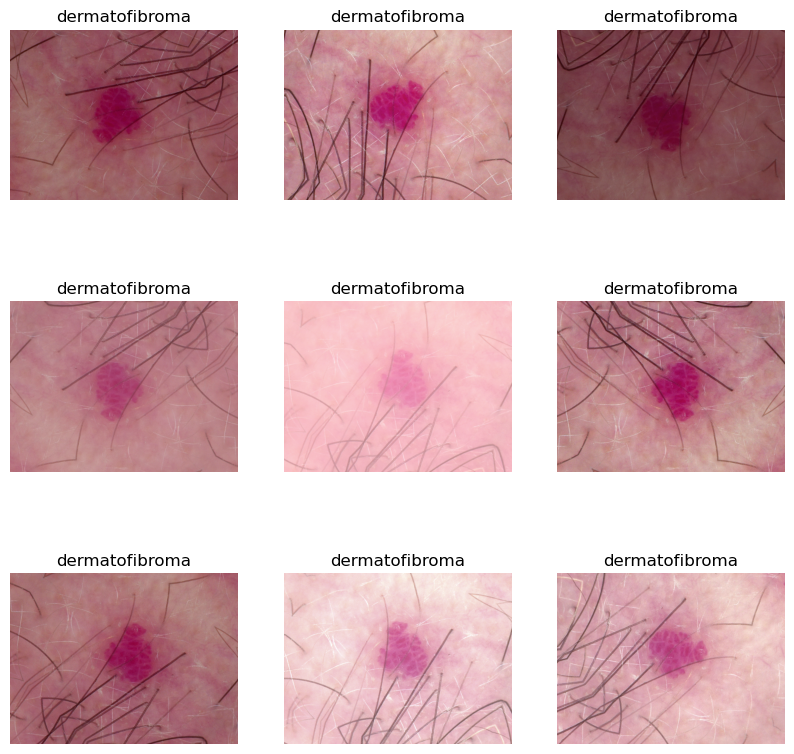

In [18]:
plt.figure(figsize=(10, 10))

for images, labels in cached_train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")

## Model Creation with Augmentation and Dropout layers [ Scenario 2 - CNN Model with Augmentation]

Note that, as well as adding the data augmentation layers, dropout layers will also be added. As per Hinton (2012), these will be placed after each of the fully connected layers with p=0.5. As per Park and Kwak (2016), we will also add some dropout after the convolution layers, but with a much reduced p of 0.1.  


In [19]:
# Modify the following variables to experiment with dropout probabilities for different layer types
dropout_conv=0.05
dropout_dense=0.25

model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),  
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])

### Model Compilation
See above for justification of optimizer choice

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model_aug_drop.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


### Model Training

In [21]:
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 13s 212ms/step - loss: 2.1495 - accuracy: 0.1998 - val_loss: 2.1986 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 12s 208ms/step - loss: 1.9768 - accuracy: 0.2606 - val_loss: 2.2359 - val_accuracy: 0.1304
Epoch 3/20
56/56 [==============================] - 12s 206ms/step - loss: 1.8601 - accuracy: 0.3225 - val_loss: 2.2243 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 12s 206ms/step - loss: 1.7928 - accuracy: 0.3477 - val_loss: 2.3195 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 12s 206ms/step - loss: 1.7094 - accuracy: 0.3923 - val_loss: 2.1570 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 12s 207ms/step - loss: 1.6535 - accuracy: 0.4068 - val_loss: 2.1303 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 12s 206ms/step - loss: 1.7061 - accuracy: 0.3890 - val_loss: 2.1693 - val_accuracy: 0.1739

### Visualization of training results

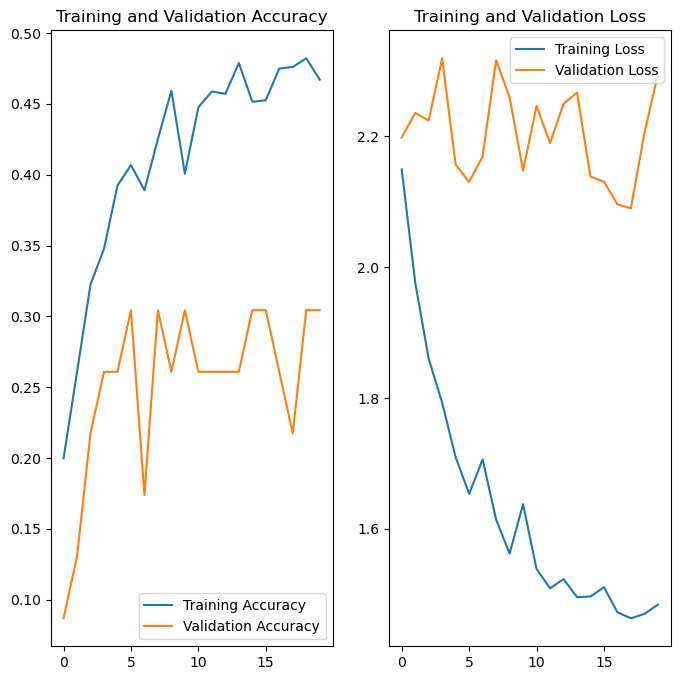

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Performance on the modified model

As can be seen, the model with augmentation layers and dropouts does not perform better on the training data, actually performing significantly worse. The model still performs poorly during inference using the validation set. There is some improvement, but the model is still overfitting.

## Display of the number of samples for each class/label

In [23]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
dtype: int64


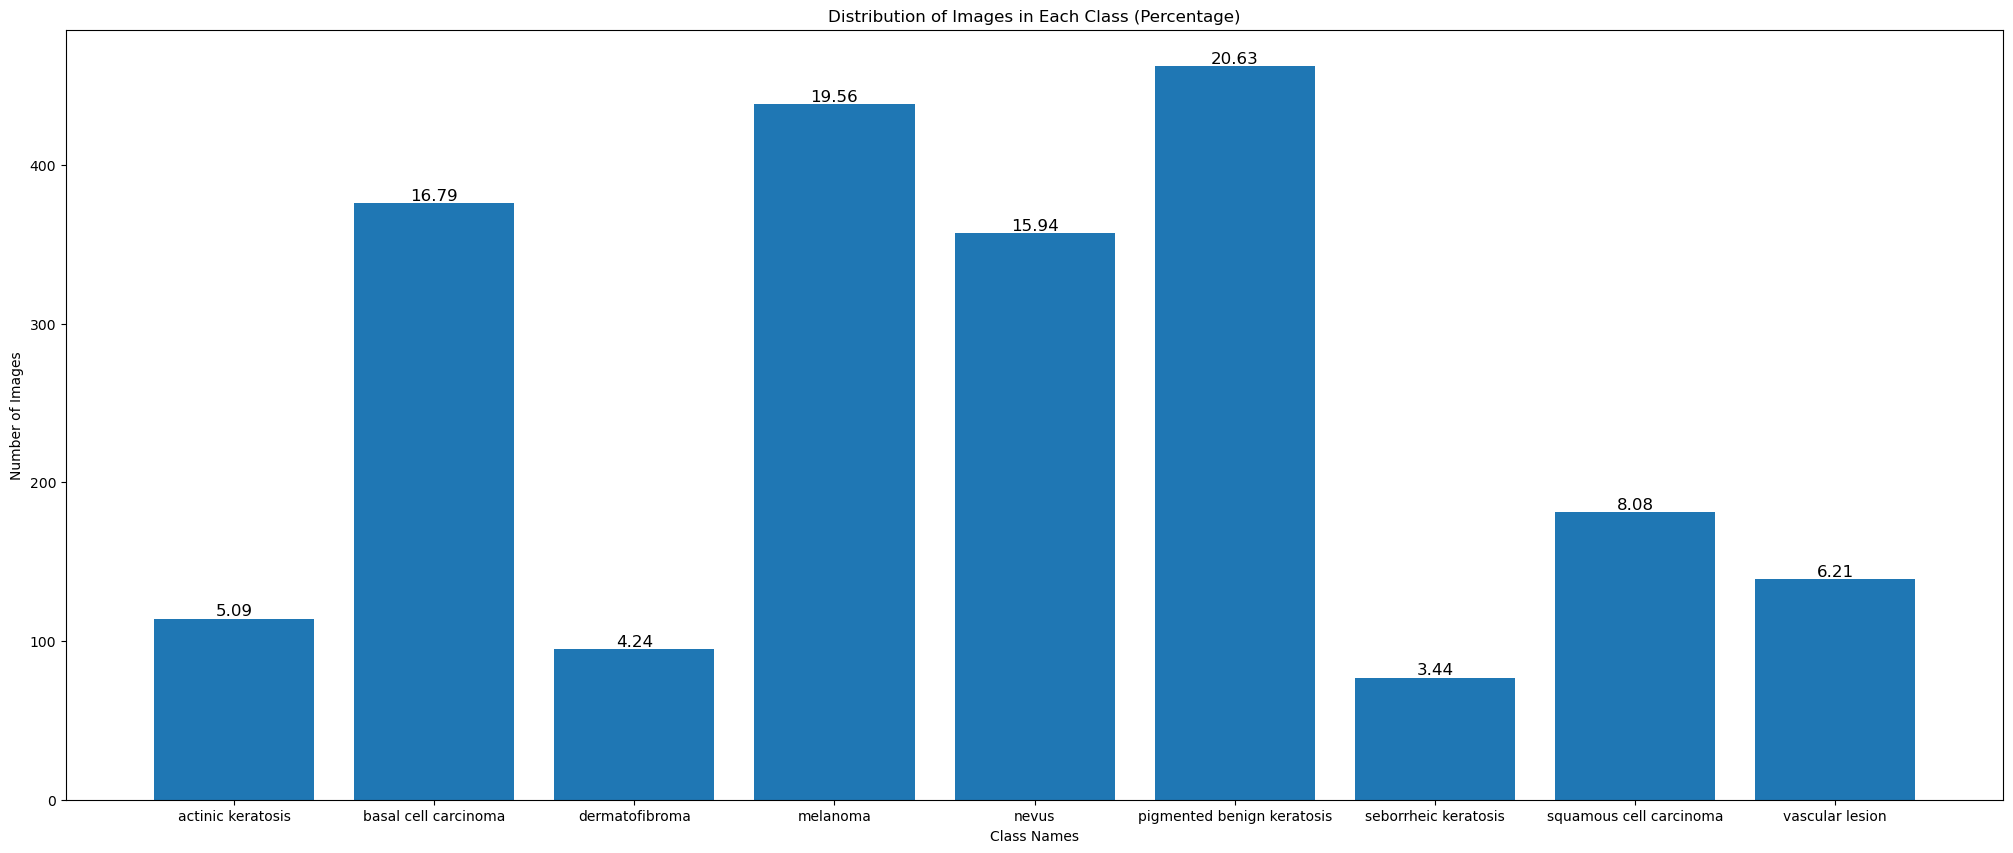

In [24]:
count = [len(list(data_dir_train.glob(f'{class_name}/*.jpg'))) for class_name in train_ds.class_names]

total_samples = sum(count)
percentages = [count[i] / total_samples * 100 for i in range(len(count))]

plt.figure(figsize=(25, 10))
bars = plt.bar(train_ds.class_names, count)

# Annotate each bar with the percentage value
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(percentage, 2), ha='center', va='bottom', fontsize=12)

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class (Percentage)')
plt.show()


### Notes on sample class distribution 
#### - Which class has the least number of samples?

Seborrheic keratosis has the least number of samples at 58

#### - Which classes dominate the data in terms proportionate number of samples?

The classes with the most samples are:
pigmented benign keratosis 370
melanoma 352
basal cell carcinoma 309
nevus 277
Clearly the classes "pigmented benign keratosis" and "melanoma" dominate the data.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CE4FD9F550>: 100%|█| 500/500 [00:02<00:00, 184.12 Samples


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CE4F441580>: 100%|█| 500/500 [00:02<00:00, 183.76 Samples


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CE4FD66370>: 100%|█| 500/500 [00:02<00:00, 174.85 Samples


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=722x545 at 0x2CE4F452AF0>: 100%|█| 500/500 [00:15<00:00, 32.96 Samples/


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2CE4FD9B4F0>: 100%|█| 500/500 [00:13<00:


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CDCCE42670>: 100%|█| 500/500 [00:03<00:00, 165.25 Samples


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2CE4FDCADF0>: 100%|█| 500/500 [00:06<00


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CE4FDB2040>: 100%|█| 500/500 [00:02<00:00, 177.34 Samples


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2CDCD09F640>: 100%|█| 500/500 [00:02<00:00, 181.28 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_10a4efc6-f407-4c59-96ac-fa2a6042798e.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2a40d3ec-0a6f-40f1-abf6-ca89815eb11d.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4db98d5f-7fe8-467c-97d2-d8368e3dfc18.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_9ccb186d-3145-4bc1-bc56-a303fe00f7bf.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_e2bd80db-6349-433a-8afe-4f0930988139.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_00648390-5053-4491-bd56-5f19530b4aec.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_5bdf8ba8-3658-4347-b5bc-eb2383701ba6.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_613bbbc8-6f7f-455c-9a16-7d3a1fc09636.jpg',
 'Train\\actinic

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

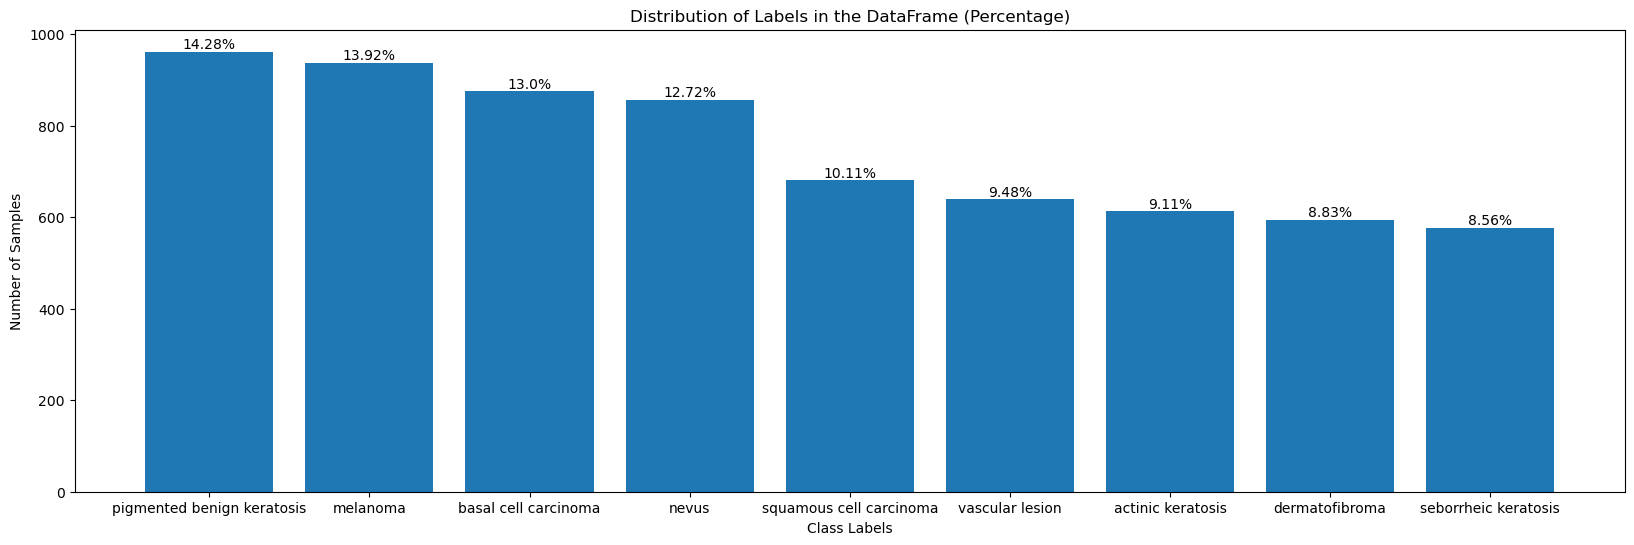

In [35]:
label_counts = new_df['Label'].value_counts()
total_samples = len(new_df)

percentages = label_counts / total_samples * 100

plt.figure(figsize=(20, 6))
bars = plt.bar(label_counts.index, label_counts)

# Annotate each bar with the percentage value
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(percentage, 2)}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in the DataFrame (Percentage)')
plt.show()


#### Handling Class Imabalancing

Now, seems to be having balanced number of images in all the classes, now let us perform the model creation, compilation on both training and validation sets.

#### Dataset Creation, Model Creation and Training

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Training dataset creation

In [37]:
data_dir_train = pathlib.Path('./Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Validation dataset creation

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model Creation (including normalization) [Scenario 3 - CNN Model by handling Class Imbalancing

#### Model Compilation

In [39]:
num_classes = len(train_ds.class_names)

# here we will add the VGG19 architecture and see the results

model_norm = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))
])

model_norm.add(Conv2D(32,(3,3),activation="relu"))

model_norm.add(BatchNormalization())
model_norm.add(MaxPooling2D(pool_size=(3,3)))

model_norm.add(Conv2D(64,(3,3),activation="relu"))

model_norm.add(BatchNormalization())
model_norm.add(MaxPooling2D(pool_size=(3,3)))

model_norm.add(Conv2D(128,(3,3),activation="relu"))
model_norm.add(BatchNormalization())

model_norm.add(Conv2D(256,(3,3),activation="relu"))
model_norm.add(BatchNormalization())

model_norm.add(MaxPooling2D(pool_size=(3,3)))
model_norm.add(Dropout(0.5))

model_norm.add(Flatten())

model_norm.add(Dense(128,activation="relu"))
model_norm.add(Dropout(0.25))
model_norm.add(Dense(num_classes,activation="softmax"))

model_norm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 57, 57, 64)       

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model_norm.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


#### Model Training
The original notebook and project pipeline contradict each other with various number of epochs given. This was reported to support with no feedback after more than a week, so 20 epochs was chosen as per the Evaluation Rubric (Note: the project pipeline asks for training for 30 epochs and some training has been tested using this value, but the code below specifies the Evaluation Rubric number.)

In [41]:
epochs = 30
history = model_norm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 617s 4s/step - loss: 2.0840 - accuracy: 0.3479 - val_loss: 3.8380 - val_accuracy: 0.0750
Epoch 2/30
169/169 [==============================] - 61s 361ms/step - loss: 1.5214 - accuracy: 0.4407 - val_loss: 2.6565 - val_accuracy: 0.2190
Epoch 3/30
169/169 [==============================] - 65s 380ms/step - loss: 1.3892 - accuracy: 0.4879 - val_loss: 1.9870 - val_accuracy: 0.3549
Epoch 4/30
169/169 [==============================] - 63s 369ms/step - loss: 1.2547 - accuracy: 0.5232 - val_loss: 1.3411 - val_accuracy: 0.5167
Epoch 5/30
169/169 [==============================] - 63s 369ms/step - loss: 1.1204 - accuracy: 0.5742 - val_loss: 1.1776 - val_accuracy: 0.5716
Epoch 6/30
169/169 [==============================] - 65s 385ms/step - loss: 1.0720 - accuracy: 0.5970 - val_loss: 2.3407 - val_accuracy: 0.2621
Epoch 7/30
169/169 [==============================] - 63s 369ms/step - loss: 0.9724 - accuracy: 0.6335 - val_loss: 2.3626 - val_accu

### Visualize the model results

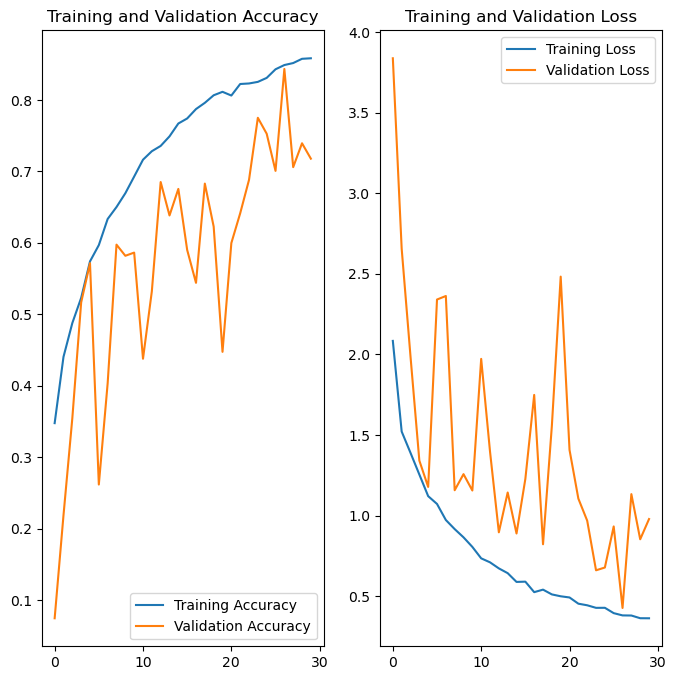

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation
The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of ~0.86 at 30 epochs, and validation accuracy at ~0.72
The accuracy is seems to be fluctuating in validation dataset and same case with loss with Batch Normalization. Lets us now consider the CNN model with hanlding class imbalances

## Model Creation (without normalization) [Scenario 3 - CNN Model by Handling Class Imbalancing

In [43]:
num_classes = len(train_ds.class_names)

model_without_norm= tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model_without_norm.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [45]:
epochs = 30
history = model_without_norm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 37s 208ms/step - loss: 1.9419 - accuracy: 0.2535 - val_loss: 1.8278 - val_accuracy: 0.3148
Epoch 2/30
169/169 [==============================] - 36s 208ms/step - loss: 1.6160 - accuracy: 0.3895 - val_loss: 1.5259 - val_accuracy: 0.4232
Epoch 3/30
169/169 [==============================] - 36s 210ms/step - loss: 1.4831 - accuracy: 0.4351 - val_loss: 1.4027 - val_accuracy: 0.4640
Epoch 4/30
169/169 [==============================] - 37s 214ms/step - loss: 1.4107 - accuracy: 0.4572 - val_loss: 1.3512 - val_accuracy: 0.4774
Epoch 5/30
169/169 [==============================] - 36s 212ms/step - loss: 1.3502 - accuracy: 0.4887 - val_loss: 1.3197 - val_accuracy: 0.4915
Epoch 6/30
169/169 [==============================] - 35s 205ms/step - loss: 1.2855 - accuracy: 0.5033 - val_loss: 1.2158 - val_accuracy: 0.5249
Epoch 7/30
169/169 [==============================] - 34s 199ms/step - loss: 1.2217 - accuracy: 0.5339 - val_loss: 1.1908 - val_ac

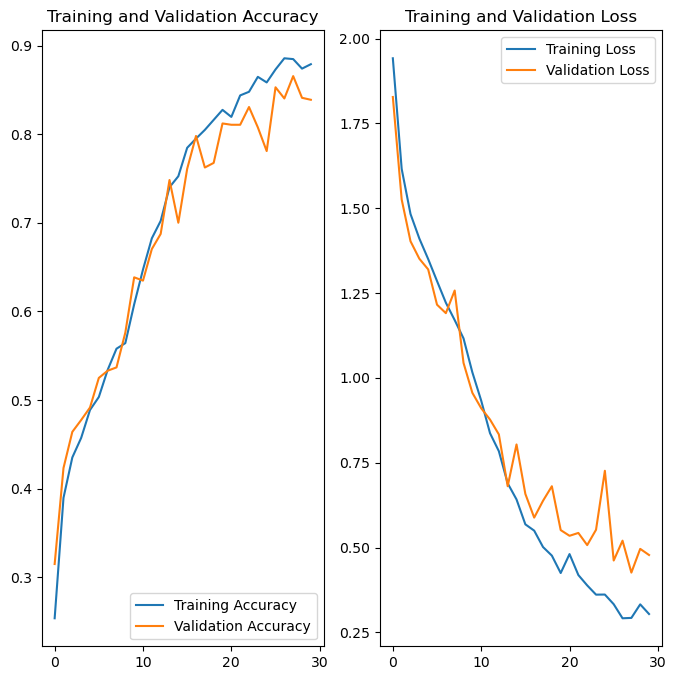

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results Analysis

The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of ~0.88 at 30 epochs, and validation accuracy at ~0.84. Judging by the large fluctuations in the validation loss, it is recommended to rerun the training with a reducing learning rate. The model seems to be jumping around a local minimum.Possibly including a callback to reduce the learning rate once an accuracy of 0.8 has been reached may lead to improvements.